# Reconstructing handwritten digits using an autoencoder
### Ref. Deep Learning with TensorFlow 2 and Keras ch.9
In the Vanilla autoencoder the number of neurons in the hidden layer are less than the number of neurons in the input (or output) layer.
This result in producing a bottleneck effect in the flow of information in the netowrok.
The hidden layer in between is also colled "bottleneck layer".
Learning in the autoencoder consists of developing a compact representation of the input signal at the hidden layer so that the output layer can faithfully reproduce the original input.

In [52]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt


## Define Custom Layers

### Encoder
The `Encoder` takes in the input and generates the hidden or the bottleneck layer as output.

In [53]:
# Create a child class from Keras Layer
class Encoder(K.layers.Layer):
    def __init__(self, hidden_dim) :
        super(Encoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, activation=tf.nn.relu)

    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

### Decoder
The `Decoder` takes in the output from the `Encoder` and then passes it through a fully connectes neural network.
The aim is to be able to reconstruct the input to the `Encoder`.

In [54]:
# Create a child class from Keras Layer
class Decoder (K.layers.Layer) :
    def __init__(self, hidden_dim, original_dim) :
        super(Decoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call (self, encoded):
        activation = self.output_layer(encoded)
        return activation

### Autoencoder
Now that we have both `Encoder` and `Decoder` defined we use the `tensorflow.Keras.Model` object to build the autoencoder model.

In [55]:
class Autoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim = original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

### Setting up some hyperparameter

In [56]:
np.random.seed(11)      # set the seed for reporoducibility
tf.random.set_seed(11)  # set the seed for reporoducibility
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

### Read the MNIST dataset

In [57]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data() # labels not used, Autoencoders learn via unsupervised learning
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))  # reshape the tensor from 2D to 1D
x_test = np.reshape(x_test, (x_test.shape[0], 784))     # reshape the tensor from 2D to 1D
trainig_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)


### Instantiate the Autoencoder and define the loss and optimizers to be used for trainig

In [58]:
autoencoder = Autoencoder(hidden_dim, original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#opt = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

### Define the train loop
Instead of using the auto-training loop, for our custom autoencoder model we will define a custom trainig, We use `tf.GradientTape` to record the gradients as they are calculated and implicity apply the gradients to all trainable variables of our model

In [59]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)    
    opt.apply_gradients(gradient_variables)
    
    return reconstruction_error

In [60]:
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

### Train the Autoencoder

In [61]:
train_loop(autoencoder, opt, loss, trainig_dataset, epochs=max_epochs)

# or, using auto-trainig loop
#autoencoder.compile(loss='mse', optimizer=opt)
#loss = autoencoder.fit(
#    x_train, 
#    x_train, 
#    validation_data = (x_test, x_test), 
#    epochs = max_epochs, 
#    batch_size = batch_size)

Epoch 1/50. Loss: 6.228333950042725
Epoch 2/50. Loss: 2.239034652709961
Epoch 3/50. Loss: 1.7826430797576904
Epoch 4/50. Loss: 1.5789154767990112
Epoch 5/50. Loss: 1.4671926498413086
Epoch 6/50. Loss: 1.3905701637268066
Epoch 7/50. Loss: 1.3329699039459229
Epoch 8/50. Loss: 1.2884517908096313
Epoch 9/50. Loss: 1.2575781345367432
Epoch 10/50. Loss: 1.2369012832641602
Epoch 11/50. Loss: 1.2226951122283936
Epoch 12/50. Loss: 1.2097374200820923
Epoch 13/50. Loss: 1.1913330554962158
Epoch 14/50. Loss: 1.1808971166610718
Epoch 15/50. Loss: 1.174067735671997
Epoch 16/50. Loss: 1.1686102151870728
Epoch 17/50. Loss: 1.1633137464523315
Epoch 18/50. Loss: 1.155277132987976
Epoch 19/50. Loss: 1.147902488708496
Epoch 20/50. Loss: 1.1434133052825928
Epoch 21/50. Loss: 1.1401448249816895
Epoch 22/50. Loss: 1.1373167037963867
Epoch 23/50. Loss: 1.134840726852417
Epoch 24/50. Loss: 1.1325809955596924
Epoch 25/50. Loss: 1.1305521726608276
Epoch 26/50. Loss: 1.1287014484405518
Epoch 27/50. Loss: 1.126997

### Plot the loss

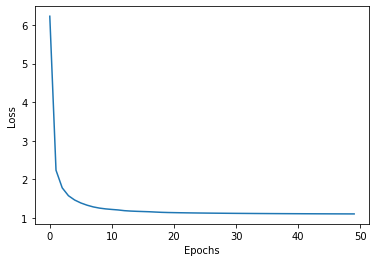

In [62]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Display reconstruced images

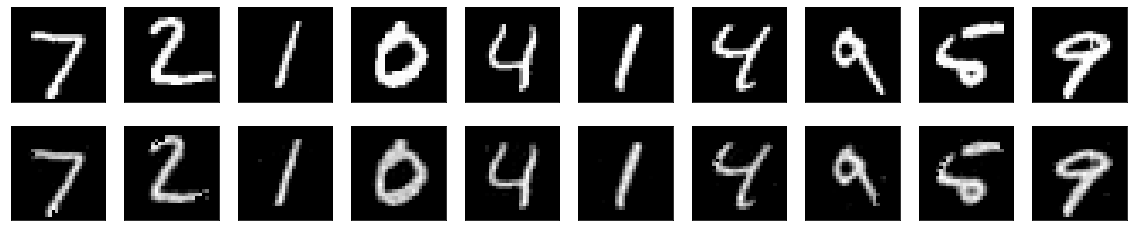

In [63]:
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()